In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [9]:
df = pd.read_csv('../../data/normalized_tweets.csv')
#Droppare colonne other cyberbullying???
#df = df[df['cyberbullying_type'] != 'other_cyberbullying']
# Reset index after filtering out the class
#df.reset_index(drop=True, inplace=True)

In [10]:
df["cyberbullying_type"].value_counts()

cyberbullying_type
religion             7932
age                  7849
ethnicity            7730
gender               7369
not_cyberbullying    6749
Name: count, dtype: int64

In [11]:
def train_evaluate_model(df, text_column, label_column, vectorizer, classifier, title, n_splits=5, binary = False,k_best_features=1000):
    # Extract features and labels
    X = df[text_column]
    y = df[label_column]

    if binary:
        y = y.astype('int')
    
    # Vectorize text data
    X_tfidf = vectorizer.fit_transform(X)

      # Feature selection
    selector = SelectKBest(chi2, k=k_best_features)
    X_tfidf_selected = selector.fit_transform(X_tfidf, y)
    
    # Define K-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    # Lists to store F1 scores for each fold
    f1_scores = []
    
    # Lists to store predicted and true labels for confusion matrix
    y_true_all = []
    y_pred_all = []
    
    # Perform K-fold cross-validation
    for train_index, test_index in kfold.split(X_tfidf_selected):
        X_train, X_test = X_tfidf_selected[train_index], X_tfidf_selected[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train classifier
        classifier.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = classifier.predict(X_test)
        
        # Calculate F1 score and accuracy
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Append score to lists
        f1_scores.append(f1)
        
        # Append true and predicted labels
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    # Calculate mean F1 score and accuracy across all folds
    mean_f1_score = np.mean(f1_scores)
    
    # Print mean scores
    print("Mean F1 Score:", mean_f1_score)
    
    # Generate classification report
    print(classification_report(y_true_all, y_pred_all))
    
    # Get the sorted list of unique class labels
    classes = sorted(df[label_column].unique())
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all, labels=classes)
    
    # Plot confusion matrix with title
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return mean_f1_score  # Return the mean F1 score

In [12]:
def find_optimal_k(df, text_column, label_column, vectorizer, classifier, k_values, n_splits=5, binary=False):
    # Dictionary to store mean F1 scores for each k
    k_f1_scores = {}

    for k in k_values:
        print(f"Evaluating k={k}")
        # Train and evaluate model with the current value of k
        f1_score = train_evaluate_model(df, text_column, label_column, vectorizer, classifier, title=f"Naive Bayes with k={k} features", n_splits=n_splits, binary=binary, k_best_features=k)
        k_f1_scores[k] = f1_score
    
    # Plot the results
    plt.plot(k_values, list(k_f1_scores.values()))
    plt.xlabel("Number of Features (k)")
    plt.ylabel("Mean F1 Score")
    plt.title("Mean F1 Score vs Number of Features")
    plt.show()
    
    return k_f1_scores

## Multinomial Naive Bayes Model
- Designed for discrete count-based data (e.g., text data represented by word frequency).	
- Features are counts of occurrences in different classes.
- Text classification, document categorization, sentiment analysis.

Mean F1 Score: 0.7136933726009838
                     precision    recall  f1-score   support

                age       0.67      0.99      0.80      7974
          ethnicity       0.82      0.92      0.87      7931
             gender       0.81      0.84      0.82      7639
  not_cyberbullying       0.69      0.31      0.43      6868
other_cyberbullying       0.61      0.30      0.40      6403
           religion       0.78      0.98      0.87      7979

           accuracy                           0.75     44794
          macro avg       0.73      0.72      0.70     44794
       weighted avg       0.73      0.75      0.71     44794



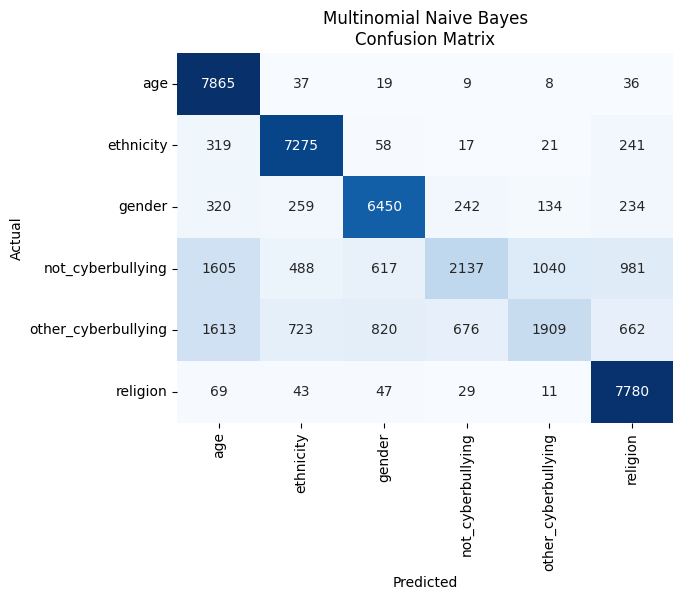

In [29]:
# Multinomial NB
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
k_values = [500, 1000, 1500, 2000, 2500]  # Adjust these values based on your dataset
optimal_k_scores = find_optimal_k(df, 'tweet_text', 'cyberbullying_type', vectorizer, classifier, k_values)

# Print optimal k and its corresponding F1 score
optimal_k = max(optimal_k_scores, key=optimal_k_scores.get)
print(f"Optimal number of features: {optimal_k}, F1 Score: {optimal_k_scores[optimal_k]}")

## Complement Naive Bayes Model
- Designed for categorical data with imbalanced classes.
- Features are represented by attribute frequencies in documents.
- Useful when classes are imbalanced and training data is limited.
- Used in text classification, document categorization, and reviews analysis applications.

Evaluating k=500
Mean F1 Score: 0.7930149999826492
                   precision    recall  f1-score   support

              age       0.69      0.98      0.81      7849
        ethnicity       0.88      0.95      0.91      7730
           gender       0.90      0.82      0.86      7369
not_cyberbullying       0.82      0.29      0.42      6749
         religion       0.87      0.97      0.92      7932

         accuracy                           0.82     37629
        macro avg       0.83      0.80      0.78     37629
     weighted avg       0.83      0.82      0.79     37629



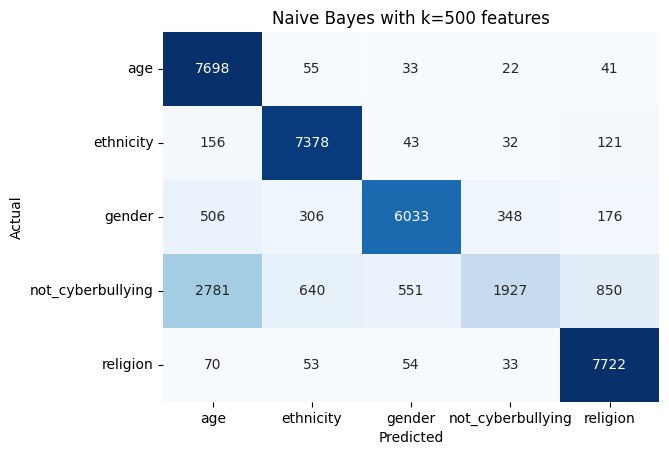

Evaluating k=1000
Mean F1 Score: 0.8123867890702183
                   precision    recall  f1-score   support

              age       0.74      0.98      0.84      7849
        ethnicity       0.88      0.95      0.91      7730
           gender       0.90      0.83      0.86      7369
not_cyberbullying       0.82      0.36      0.50      6749
         religion       0.85      0.98      0.91      7932

         accuracy                           0.83     37629
        macro avg       0.84      0.82      0.80     37629
     weighted avg       0.84      0.83      0.81     37629



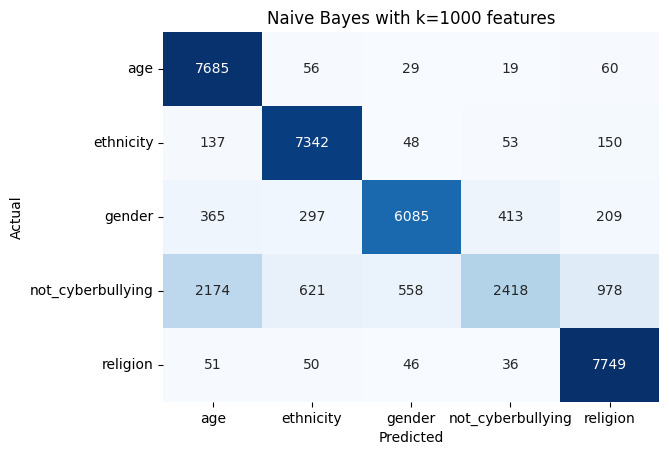

Evaluating k=1500
Mean F1 Score: 0.8235748111815105
                   precision    recall  f1-score   support

              age       0.76      0.98      0.86      7849
        ethnicity       0.88      0.95      0.91      7730
           gender       0.90      0.83      0.86      7369
not_cyberbullying       0.84      0.40      0.54      6749
         religion       0.84      0.98      0.91      7932

         accuracy                           0.84     37629
        macro avg       0.84      0.83      0.82     37629
     weighted avg       0.84      0.84      0.82     37629



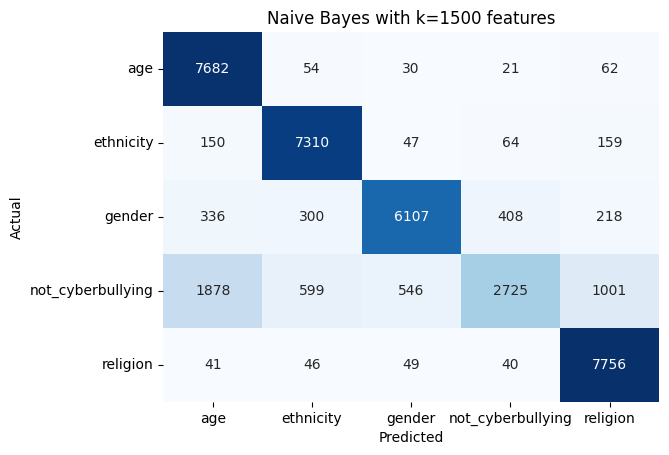

Evaluating k=2000
Mean F1 Score: 0.8309124085194238
                   precision    recall  f1-score   support

              age       0.78      0.98      0.87      7849
        ethnicity       0.88      0.94      0.91      7730
           gender       0.90      0.83      0.86      7369
not_cyberbullying       0.84      0.43      0.57      6749
         religion       0.84      0.98      0.91      7932

         accuracy                           0.84     37629
        macro avg       0.85      0.83      0.82     37629
     weighted avg       0.85      0.84      0.83     37629



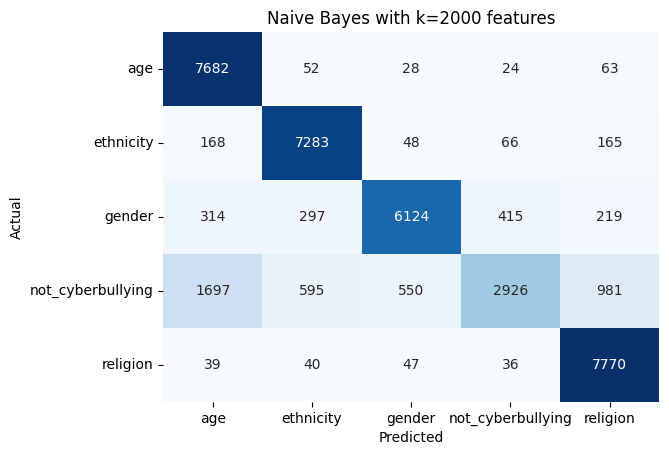

Evaluating k=2500
Mean F1 Score: 0.8340409692228192
                   precision    recall  f1-score   support

              age       0.78      0.98      0.87      7849
        ethnicity       0.88      0.94      0.91      7730
           gender       0.90      0.83      0.87      7369
not_cyberbullying       0.85      0.45      0.59      6749
         religion       0.84      0.98      0.91      7932

         accuracy                           0.85     37629
        macro avg       0.85      0.84      0.83     37629
     weighted avg       0.85      0.85      0.83     37629



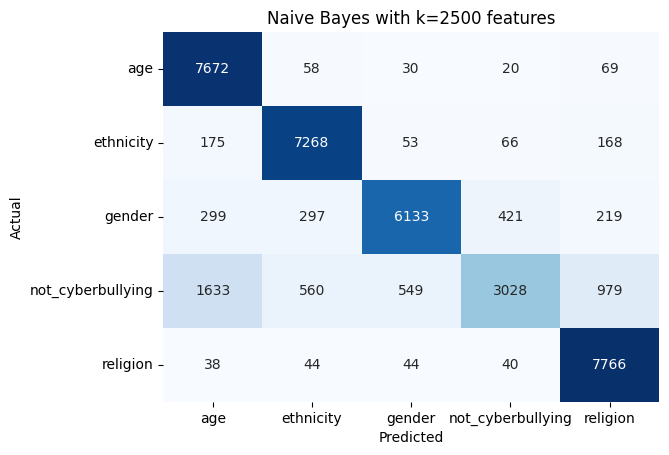

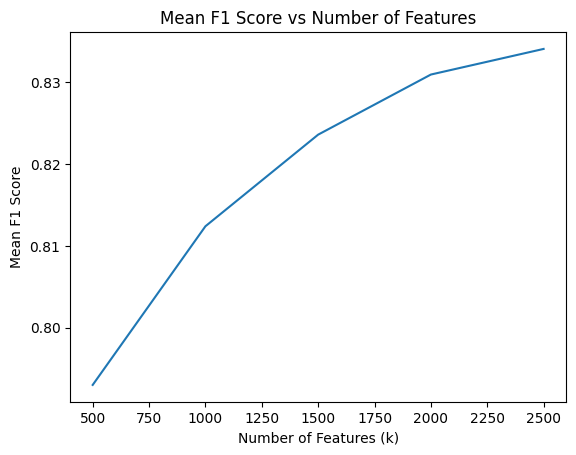

Optimal number of features: 2500, F1 Score: 0.8340409692228192


In [15]:
# Multinomial NB
vectorizer = TfidfVectorizer()
classifier = ComplementNB()
k_values = [500, 1000, 1500, 2000, 2500]  # Adjust these values based on your dataset
optimal_k_scores = find_optimal_k(df, 'tweet_text', 'cyberbullying_type', vectorizer, classifier, k_values)

# Print optimal k and its corresponding F1 score
optimal_k = max(optimal_k_scores, key=optimal_k_scores.get)
print(f"Optimal number of features: {optimal_k}, F1 Score: {optimal_k_scores[optimal_k]}")

## Bernoulli Naive Bayes Model

- Designed for discrete count-based data, such as text data represented by word frequency.
- Features are counts of occurrences in different classes.
- Commonly used in text classification, document categorization, and sentiment analysis tasks.

Evaluating k=500
Mean F1 Score: 0.9065875516199714
                   precision    recall  f1-score   support

              age       0.98      0.97      0.98      7849
        ethnicity       0.97      0.93      0.95      7730
           gender       0.95      0.78      0.86      7369
not_cyberbullying       0.72      0.89      0.80      6749
         religion       0.94      0.94      0.94      7932

         accuracy                           0.90     37629
        macro avg       0.91      0.90      0.90     37629
     weighted avg       0.92      0.90      0.91     37629



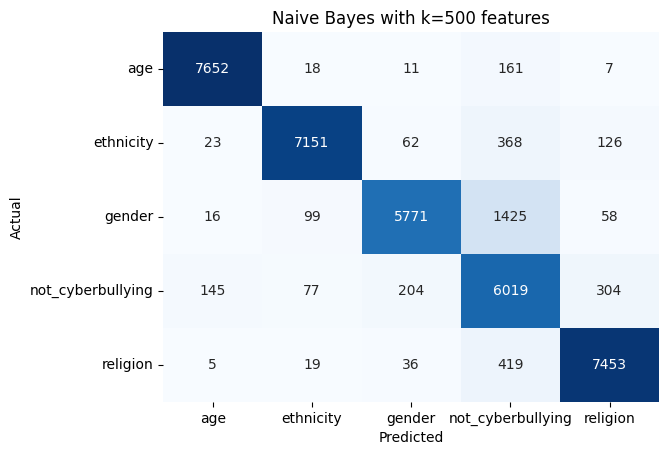

Evaluating k=1000
Mean F1 Score: 0.9074907800232422
                   precision    recall  f1-score   support

              age       0.97      0.98      0.97      7849
        ethnicity       0.97      0.93      0.95      7730
           gender       0.94      0.79      0.86      7369
not_cyberbullying       0.73      0.89      0.80      6749
         religion       0.94      0.94      0.94      7932

         accuracy                           0.91     37629
        macro avg       0.91      0.90      0.90     37629
     weighted avg       0.91      0.91      0.91     37629



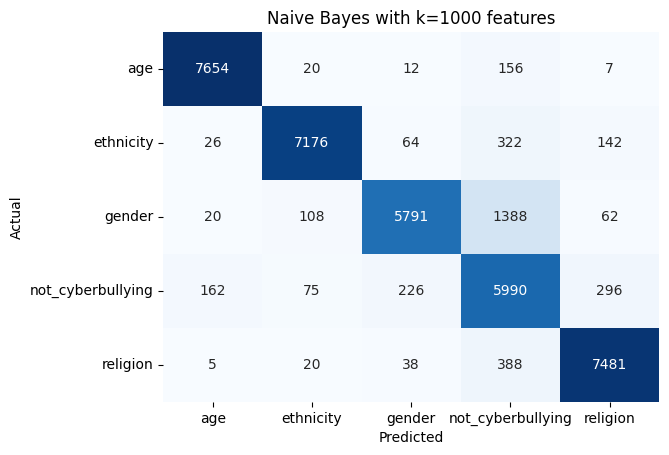

Evaluating k=1500
Mean F1 Score: 0.9072571364823518
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      7849
        ethnicity       0.97      0.93      0.95      7730
           gender       0.94      0.79      0.86      7369
not_cyberbullying       0.73      0.89      0.80      6749
         religion       0.94      0.94      0.94      7932

         accuracy                           0.91     37629
        macro avg       0.91      0.90      0.90     37629
     weighted avg       0.91      0.91      0.91     37629



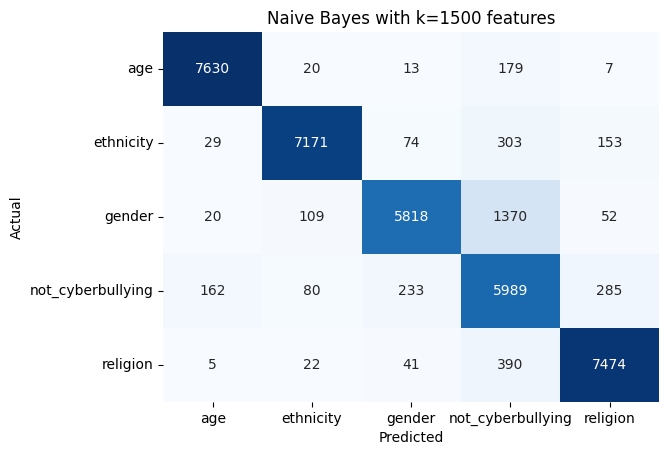

Evaluating k=2000
Mean F1 Score: 0.9073111526283851
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      7849
        ethnicity       0.97      0.93      0.95      7730
           gender       0.94      0.79      0.86      7369
not_cyberbullying       0.73      0.89      0.80      6749
         religion       0.94      0.94      0.94      7932

         accuracy                           0.91     37629
        macro avg       0.91      0.90      0.90     37629
     weighted avg       0.91      0.91      0.91     37629



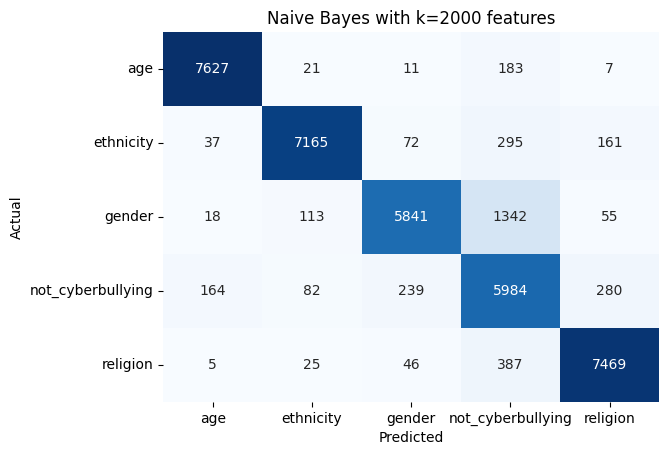

Evaluating k=2500
Mean F1 Score: 0.9070268216074318
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      7849
        ethnicity       0.97      0.93      0.95      7730
           gender       0.94      0.79      0.86      7369
not_cyberbullying       0.73      0.89      0.80      6749
         religion       0.94      0.94      0.94      7932

         accuracy                           0.91     37629
        macro avg       0.91      0.90      0.90     37629
     weighted avg       0.91      0.91      0.91     37629



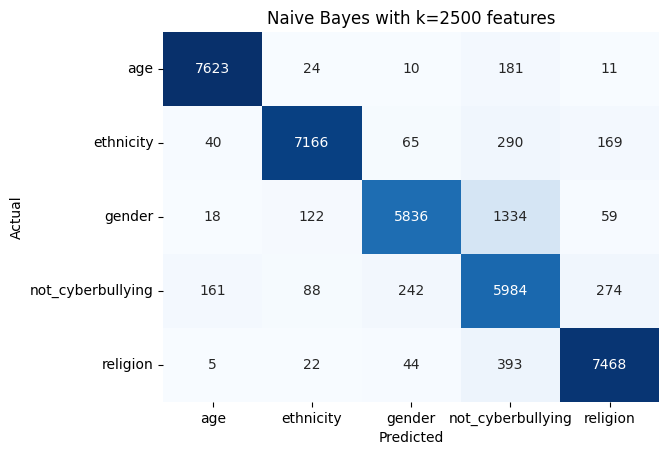

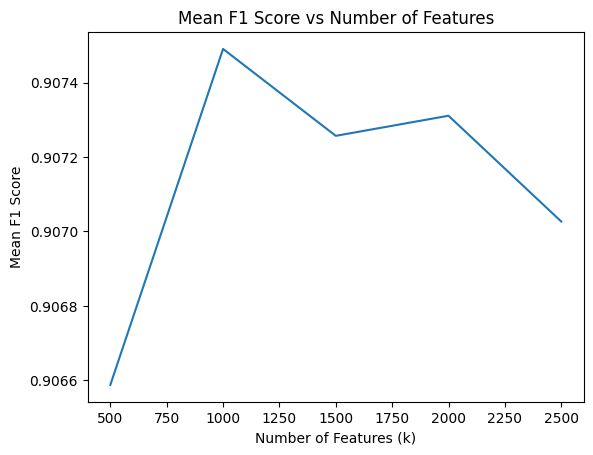

Optimal number of features: 1000, F1 Score: 0.9074907800232422


In [16]:
# Multinomial NB
vectorizer = TfidfVectorizer()
classifier = BernoulliNB()
k_values = [500, 1000, 1500, 2000, 2500]  # Adjust these values based on your dataset
optimal_k_scores = find_optimal_k(df, 'tweet_text', 'cyberbullying_type', vectorizer, classifier, k_values)

# Print optimal k and its corresponding F1 score
optimal_k = max(optimal_k_scores, key=optimal_k_scores.get)
print(f"Optimal number of features: {optimal_k}, F1 Score: {optimal_k_scores[optimal_k]}")

# Binary Naive Bayes Classifier

From the original dataset, we selected all the tweets labeled as "not_cyberbullying" and assigned them the category 1. Since there were 7815 such tweets, to achieve a balanced distribution, we selected 1563 tweets for each cyberbullying category and assigned them label 0.

In [21]:
df = pd.read_csv('../../data/normalized_tweets.csv')

# if we drop 'other_cyberbullyng', n changes
df = df[df['cyberbullying_type'] != 'other_cyberbullying']
n = 1953

#n = 1563

# Create an empty dataframe for the results
result_df = pd.DataFrame(columns=['tweet_text', 'label'])

# Ensure labels are integers
result_df['label'] = result_df['label'].astype(int)

for category in df['cyberbullying_type'].unique():
    if category != 'not_cyberbullying':
        sampled_df = df[df['cyberbullying_type'] == category].sample(n=n, replace=False)
        sampled_df.loc[:, 'label'] = 0  
        result_df = pd.concat([result_df, sampled_df[['tweet_text', 'label']]], ignore_index=True)
    else:
        other_cyberbullying_df = df[df['cyberbullying_type'] == category].copy() 
        other_cyberbullying_df.loc[:, 'label'] = 1 
        result_df = pd.concat([result_df, other_cyberbullying_df[['tweet_text', 'label']]], ignore_index=True)


## Multinomial Naive Bayes Model

Evaluating k=500
Mean F1 Score: 0.7096277086973635
              precision    recall  f1-score   support

           0       0.67      0.96      0.79      7812
           1       0.92      0.46      0.61      6749

    accuracy                           0.73     14561
   macro avg       0.80      0.71      0.70     14561
weighted avg       0.79      0.73      0.71     14561



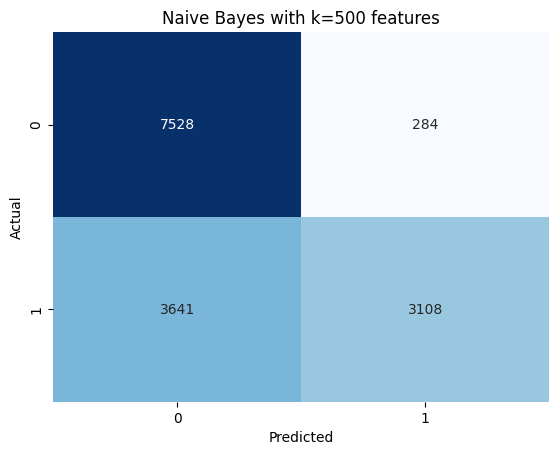

Evaluating k=1000
Mean F1 Score: 0.7592851871371391
              precision    recall  f1-score   support

           0       0.71      0.96      0.82      7812
           1       0.93      0.55      0.69      6749

    accuracy                           0.77     14561
   macro avg       0.82      0.76      0.75     14561
weighted avg       0.81      0.77      0.76     14561



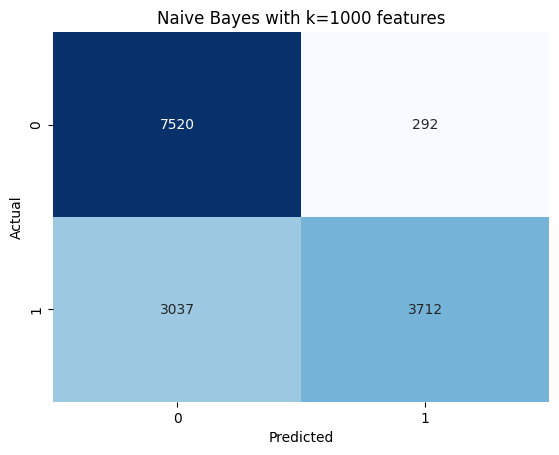

Evaluating k=1500
Mean F1 Score: 0.7826488295621906
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      7812
           1       0.94      0.59      0.72      6749

    accuracy                           0.79     14561
   macro avg       0.83      0.78      0.78     14561
weighted avg       0.83      0.79      0.78     14561



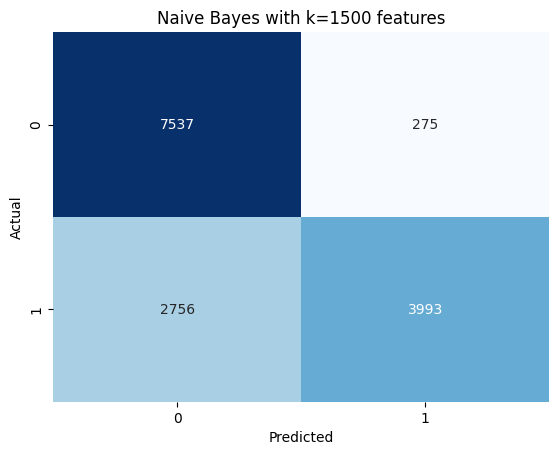

Evaluating k=2000
Mean F1 Score: 0.7945567240786015
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      7812
           1       0.94      0.61      0.74      6749

    accuracy                           0.80     14561
   macro avg       0.84      0.79      0.79     14561
weighted avg       0.83      0.80      0.79     14561



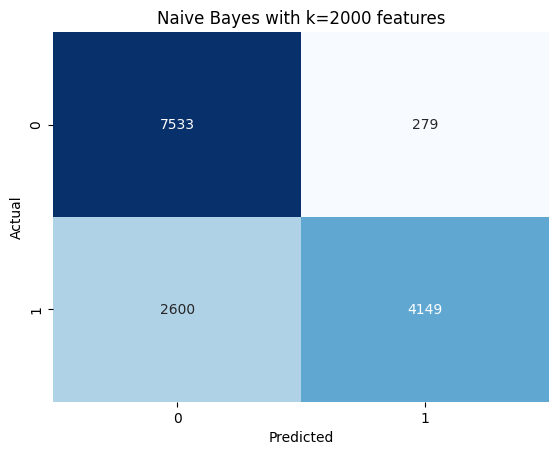

Evaluating k=2500
Mean F1 Score: 0.8046250916382011
              precision    recall  f1-score   support

           0       0.75      0.97      0.85      7812
           1       0.94      0.63      0.76      6749

    accuracy                           0.81     14561
   macro avg       0.85      0.80      0.80     14561
weighted avg       0.84      0.81      0.80     14561



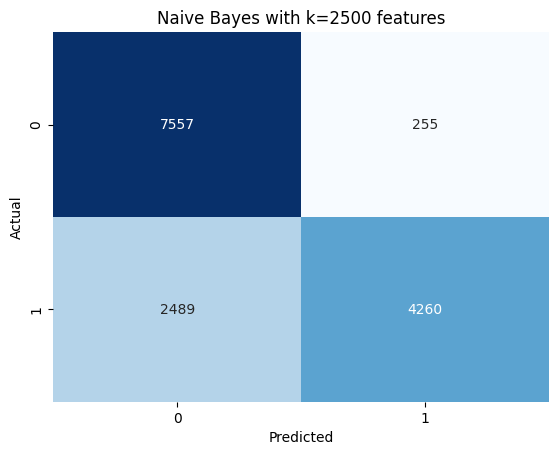

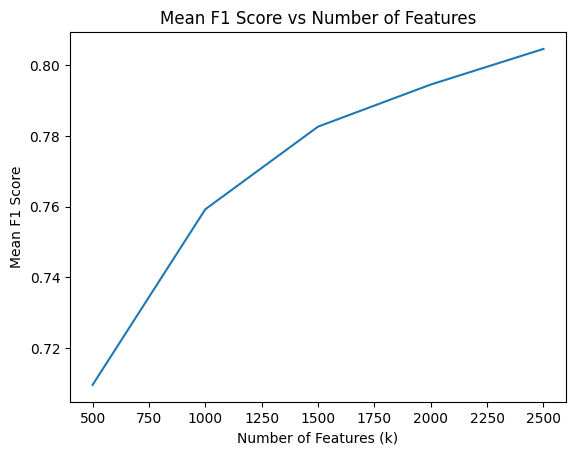

Optimal number of features: 2500, F1 Score: 0.8046250916382011


In [22]:
# Multinomial NB
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
k_values = [500, 1000, 1500, 2000, 2500]  # Adjust these values based on your dataset
optimal_k_scores = find_optimal_k(result_df, 'tweet_text', 'label', vectorizer, classifier, k_values)

# Print optimal k and its corresponding F1 score
optimal_k = max(optimal_k_scores, key=optimal_k_scores.get)
print(f"Optimal number of features: {optimal_k}, F1 Score: {optimal_k_scores[optimal_k]}")

## Complement Naive Bayes Model

Evaluating k=500
Mean F1 Score: 0.7519485351517301
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      7812
           1       0.90      0.55      0.68      6749

    accuracy                           0.76     14561
   macro avg       0.80      0.75      0.75     14561
weighted avg       0.80      0.76      0.75     14561



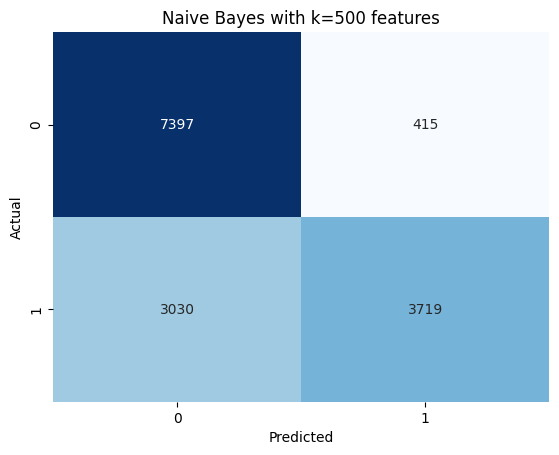

Evaluating k=1000
Mean F1 Score: 0.7763276735272404
              precision    recall  f1-score   support

           0       0.73      0.95      0.83      7812
           1       0.91      0.60      0.72      6749

    accuracy                           0.78     14561
   macro avg       0.82      0.77      0.77     14561
weighted avg       0.81      0.78      0.78     14561



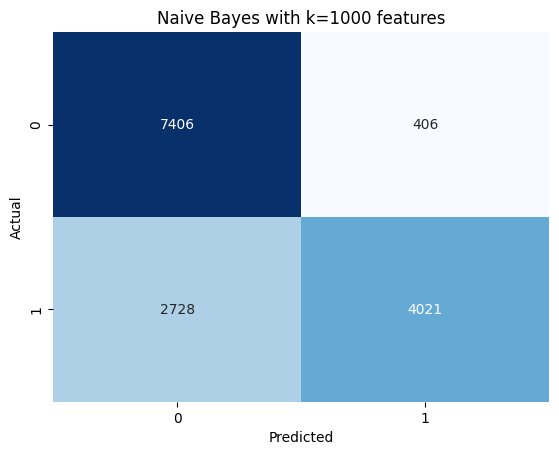

Evaluating k=1500
Mean F1 Score: 0.7985121879326318
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      7812
           1       0.92      0.64      0.75      6749

    accuracy                           0.80     14561
   macro avg       0.83      0.79      0.80     14561
weighted avg       0.83      0.80      0.80     14561



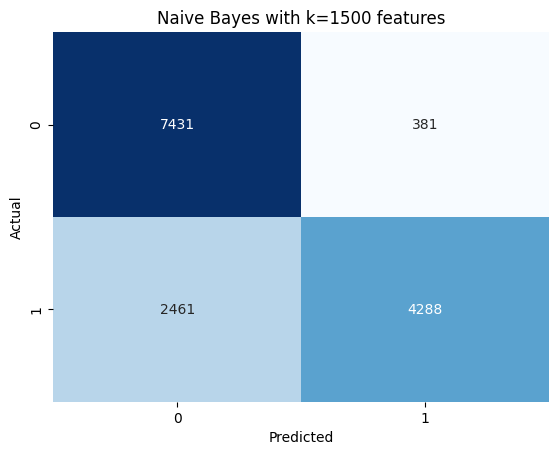

Evaluating k=2000
Mean F1 Score: 0.817063237928765
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      7812
           1       0.93      0.67      0.78      6749

    accuracy                           0.82     14561
   macro avg       0.85      0.81      0.81     14561
weighted avg       0.84      0.82      0.82     14561



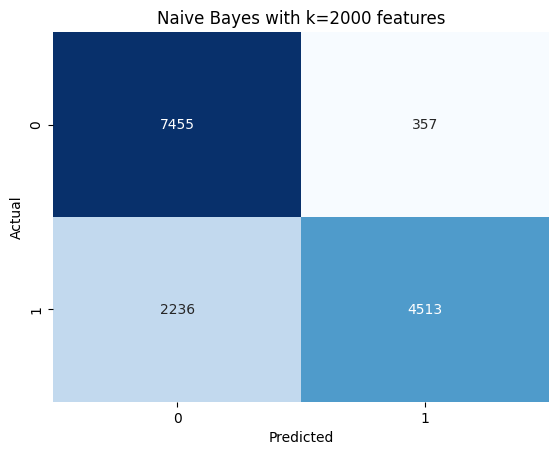

Evaluating k=2500
Mean F1 Score: 0.8259869345435543
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      7812
           1       0.93      0.68      0.79      6749

    accuracy                           0.83     14561
   macro avg       0.85      0.82      0.82     14561
weighted avg       0.85      0.83      0.83     14561



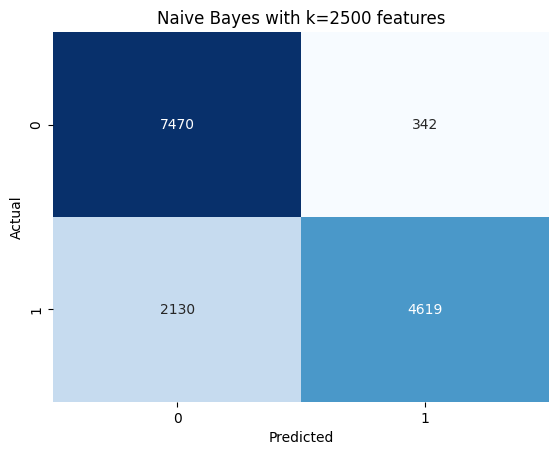

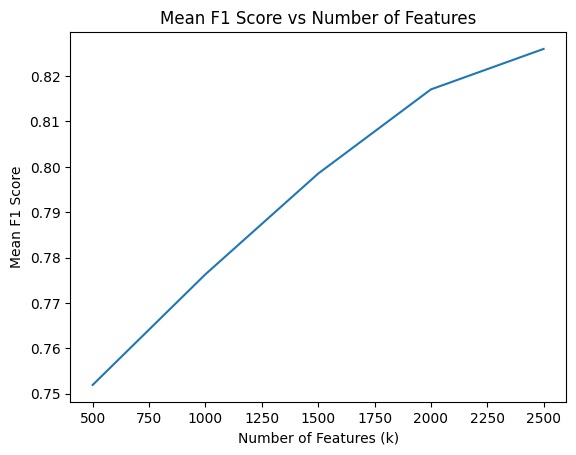

Optimal number of features: 2500, F1 Score: 0.8259869345435543


In [23]:
# Multinomial NB
vectorizer = TfidfVectorizer()
classifier = ComplementNB()
k_values = [500, 1000, 1500, 2000, 2500]  # Adjust these values based on your dataset
optimal_k_scores = find_optimal_k(result_df, 'tweet_text', 'label', vectorizer, classifier, k_values)

# Print optimal k and its corresponding F1 score
optimal_k = max(optimal_k_scores, key=optimal_k_scores.get)
print(f"Optimal number of features: {optimal_k}, F1 Score: {optimal_k_scores[optimal_k]}")

## Bernoulli Naive Bayes Model

Evaluating k=500
Mean F1 Score: 0.9040984754711919
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      7812
           1       0.88      0.92      0.90      6749

    accuracy                           0.90     14561
   macro avg       0.90      0.91      0.90     14561
weighted avg       0.91      0.90      0.90     14561



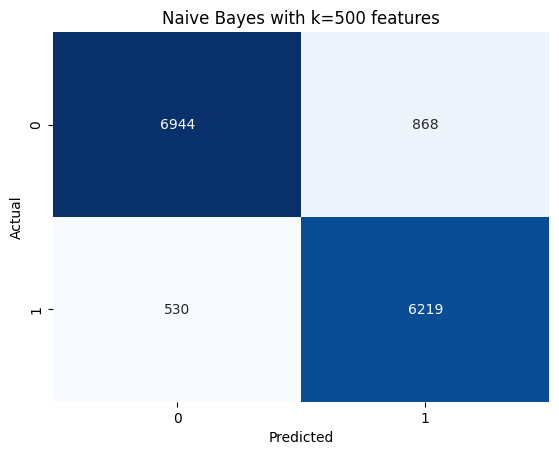

Evaluating k=1000
Mean F1 Score: 0.9068386922812156
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      7812
           1       0.88      0.92      0.90      6749

    accuracy                           0.91     14561
   macro avg       0.91      0.91      0.91     14561
weighted avg       0.91      0.91      0.91     14561



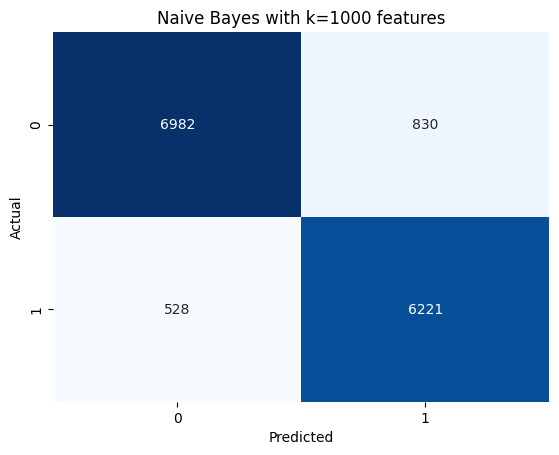

Evaluating k=1500
Mean F1 Score: 0.9098638765960121
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      7812
           1       0.88      0.93      0.91      6749

    accuracy                           0.91     14561
   macro avg       0.91      0.91      0.91     14561
weighted avg       0.91      0.91      0.91     14561



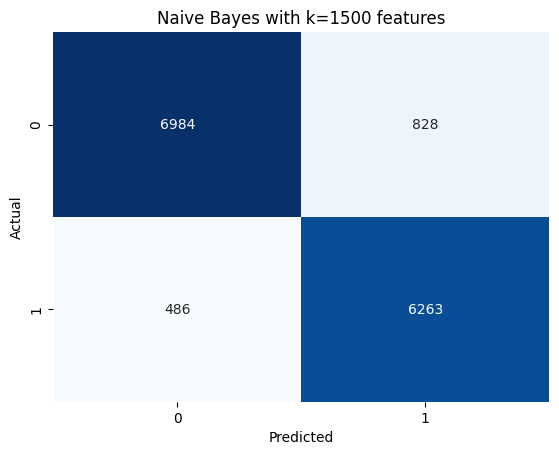

Evaluating k=2000
Mean F1 Score: 0.9116368225423279
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7812
           1       0.89      0.93      0.91      6749

    accuracy                           0.91     14561
   macro avg       0.91      0.91      0.91     14561
weighted avg       0.91      0.91      0.91     14561



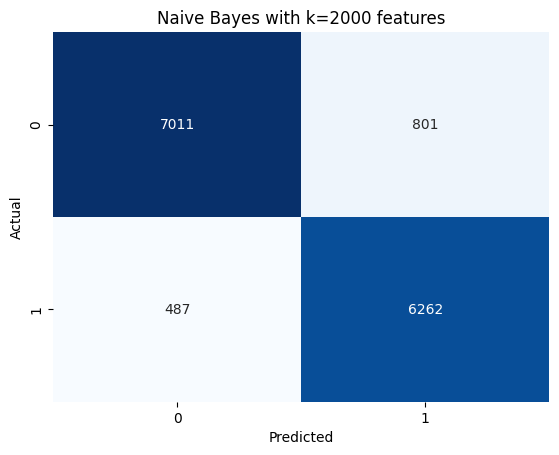

Evaluating k=2500
Mean F1 Score: 0.9110972578241894
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      7812
           1       0.89      0.93      0.91      6749

    accuracy                           0.91     14561
   macro avg       0.91      0.91      0.91     14561
weighted avg       0.91      0.91      0.91     14561



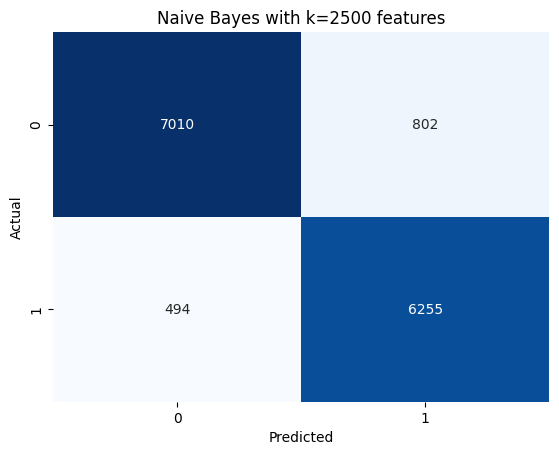

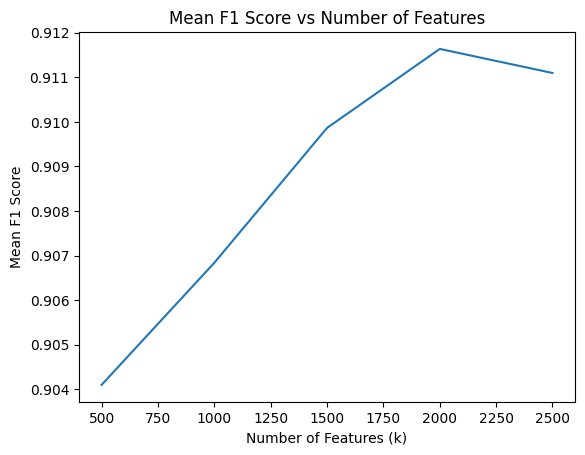

Optimal number of features: 2000, F1 Score: 0.9116368225423279


In [24]:
# Multinomial NB
vectorizer = TfidfVectorizer()
classifier = BernoulliNB()
k_values = [500, 1000, 1500, 2000, 2500]  # Adjust these values based on your dataset
optimal_k_scores = find_optimal_k(result_df, 'tweet_text', 'label', vectorizer, classifier, k_values)

# Print optimal k and its corresponding F1 score
optimal_k = max(optimal_k_scores, key=optimal_k_scores.get)
print(f"Optimal number of features: {optimal_k}, F1 Score: {optimal_k_scores[optimal_k]}")